In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import gc
from tqdm.autonotebook import tqdm

from sklearn.metrics import accuracy_score,f1_score

import sklearn

import torch
from simpletransformers.classification import ClassificationModel

In [4]:
train_data = pd.read_csv("/content/I-Sarcasm_train_.csv")
test_data = pd.read_csv("/content/I-Sarcasm_test_.csv")

In [5]:
train_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,NaN
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,NaN
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,NaN
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,NaN
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [6]:
test_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,NaN
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,NaN
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,NaN
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [21]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train_data.drop("tweet_id",inplace=True,axis=1)

In [22]:
train_tweets=train_data['tweet'].tolist()
test_tweets=test_data['tweet'].tolist()


In [23]:
train_data.describe().T

,count,unique,top,freq
tweet,3577,3523,LOL...Walker is talking about education...the ...,3
sarcasm_label,3577,2,not_sarcastic,2297
sarcasm_type,1279,7,sarcasm,880


In [24]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [25]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [15]:
tqdm.pandas() 

train_data['cleaned_text']= train_data['tweet'].progress_apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweet'].progress_apply((lambda x: clean(x)))

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

In [26]:
train_data.drop("sarcasm_type",inplace=True,axis=1)
train_data.head()

,tweet,sarcasm_label
2824,@Paytmcare thanks for the quick revert #lol #s...,sarcastic
866,SMTM4 is really such a great drama.. The best ...,sarcastic
2771,Thanks @panerabread for the generous one piece...,sarcastic
1083,@kimberlymoffit And the same to you! #late tweet,not_sarcastic
1351,See the well #trained #consumer absolute minim...,not_sarcastic


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


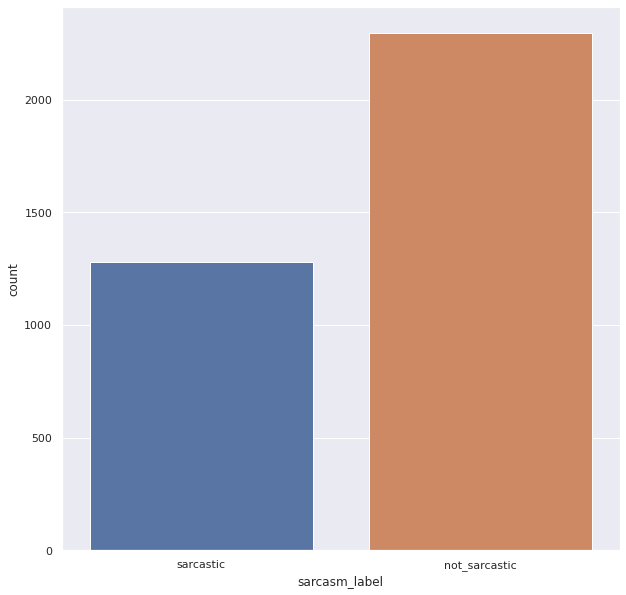

In [27]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['sarcasm_label'])

In [29]:
train_data.head()

,tweet,sarcasm_label
2824,@Paytmcare thanks for the quick revert #lol #s...,sarcastic
866,SMTM4 is really such a great drama.. The best ...,sarcastic
2771,Thanks @panerabread for the generous one piece...,sarcastic
1083,@kimberlymoffit And the same to you! #late tweet,not_sarcastic
1351,See the well #trained #consumer absolute minim...,not_sarcastic


Text(0.5, 1.0, 'Sarcastic Tweets')

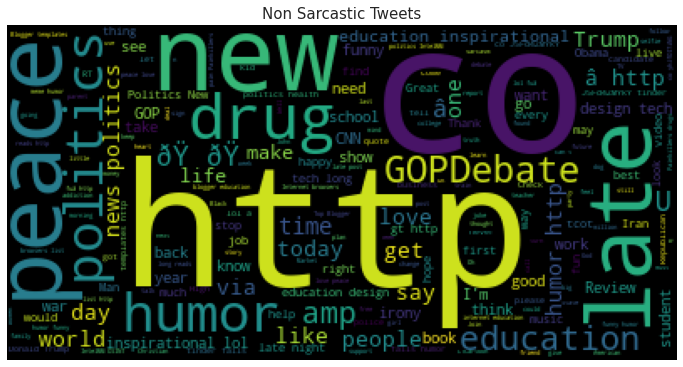

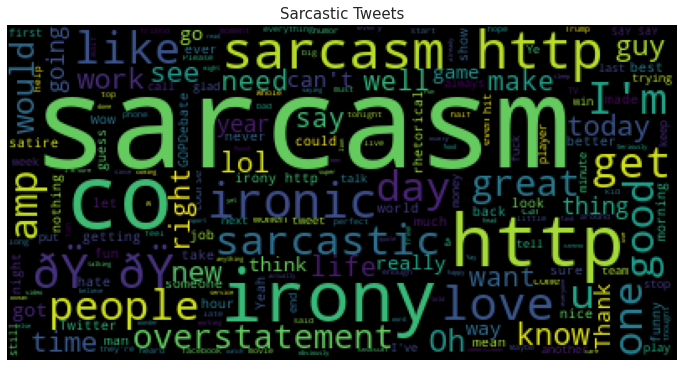

In [35]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,10))
text = ' '.join(train_data.tweet[train_data['sarcasm_label']=='not_sarcastic'])
wc = WordCloud(background_color='black',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Non Sarcastic Tweets',fontsize=15)



plt.figure(figsize=(12,10))
text = ' '.join(train_data.tweet[train_data['sarcasm_label']=='sarcastic'])
wc2 = WordCloud(background_color='black',stopwords=stopwords).generate(text)
plt.imshow(wc2)
plt.axis('off')
plt.title('Sarcastic Tweets',fontsize=15)



In [36]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'not_sarcastic':0,
        'sarcastic':1
    }
    return class_dict[t_class]

In [37]:
train_data["target"] = train_data['sarcasm_label'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['sarcasm_label'].apply(lambda x: encode_target(x))

In [39]:
train = train_data[['tweet','target']]
train.columns = ['text','labels']

test = test_data[['tweet','target']]
test.columns = ['text','labels']

In [40]:
train.head()

,text,labels
2824,@Paytmcare thanks for the quick revert #lol #s...,1
866,SMTM4 is really such a great drama.. The best ...,1
2771,Thanks @panerabread for the generous one piece...,1
1083,@kimberlymoffit And the same to you! #late tweet,0
1351,See the well #trained #consumer absolute minim...,0


In [41]:
test.head()

,text,labels
597,#news RT TiffanyKHOU: 1 deputy had the idea an...,0
35,Hungary bars migrants from trains; smugglers w...,0
835,@CRCRockwood Had a great time at Emerald Lake ...,1
18,Thank you McDonald's commercial for playing th...,1
454,"Girl, 16, dies of wounds suffered in attack on...",1


In [44]:
model = ClassificationModel(
    "bert", "dbmdz/bert-base-turkish-cased",
    num_labels=4,
    args=train_args
)

NameError: ignored

In [56]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 128,
               'gradient_accumulation_steps': 2,
#                'do_lower_case': True,
               'learning_rate': 1e-5,
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 4}


In [57]:
model = ClassificationModel(model_type, model_name,num_labels=4,args=model_args,use_cuda=False) 
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=train_args
# ) 
#args=model_args


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [58]:
model.train_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/28 [00:00<?, ?it/s]

(56, 0.8822310822350639)

In [59]:
result, model_outputs, wrong_predictions = model.eval_model(test,acc=accuracy_score)

  0%|          | 0/907 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [60]:
print("TEST SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result['acc']*100))
print("%s: %.5f" % ('Final Loss', result['eval_loss']))

TEST SET EVALUATION:
Accuracy: 81.04%
Final Loss: 0.56715
